# 5. K-fold cross-validation (Part 1 - accuracy)

In [1]:
import numpy as np
import torch

In [2]:
# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)

In [3]:
# load dataset
from GPErks.serialization.labels import read_labels_from_file
data_dir = "data/example_4/"
X_ = np.loadtxt(data_dir + "X.txt", dtype=float)[:80]
y_ = np.loadtxt(data_dir + "y.txt", dtype=float)[:80]
xlabels = read_labels_from_file(data_dir + "xlabels.txt")
ylabel = read_labels_from_file(data_dir + "ylabel.txt")[0]

In [4]:
# split dataset in training and validation sets
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(
    X_,
    y_,
    test_size=0.2,
    random_state=seed
)


<br/>

**Example**: 5-fold cross-"validation" splitting strategy

<br/>

| X      | X_val |
| :---        |    :----:   |
| X1234 + X5      | X_val       |
| X1235 + X4      | X_val       |
| X1245 + X3      | X_val       |
| X1345 + X2      | X_val       |
| X2345 + X1      | X_val       |

<br/>


In [5]:
# build dataset
from GPErks.gp.data.dataset import Dataset
dataset = Dataset(
    X,
    y,
    X_val=X_val,
    y_val=y_val,
    x_labels=xlabels,
    y_label=ylabel,
    name="CanopyReflectance",
    descr="A reflectance model for the homogeneous plant canopy and its inversion (doi.org/10.1016/0034-4257(89)90015-1)",
)
dataset.summary()


CanopyReflectance dataset loaded.
Notes from the author:
"A reflectance model for the homogeneous plant canopy and its inversion (doi.org/10.1016/0034-4257(89)90015-1)"
Dataset properties:
-Input size: 5
-Input parameters: ['view_zenith', 'LAI', 'sl', 'lmbd_z', 'lambda']
-Output size: 1
-Output feature: ['Canopy_Reflectance']
-Sample size: 64
-Discrepancy: 0.0329
-Validation data available: Yes (size = 16)
-Testing data available: No


In [6]:
# define experiment
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
from GPErks.gp.experiment import GPExperiment

likelihood = GaussianLikelihood()
mean_function = LinearMean(input_size=dataset.input_size)
kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))
metrics = [MeanSquaredError(), R2Score()]

experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed,
    learn_noise=True
)

/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# k-fold cross-validation training

from GPErks.perks.cross_validation import KFoldCrossValidation
from GPErks.train.early_stop import GLEarlyStoppingCriterion

device = "cpu"
devices = [device]  # a list of devices, in this case we are passing just one
kfcv = KFoldCrossValidation(experiment, devices, n_splits=5, max_workers=1)

optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)
esc = GLEarlyStoppingCriterion(max_epochs=1000, alpha=0.1, patience=8)
# similarly to simple training, when doing cross-validation we can again output both
# the best model state (a dict) and its training statistics (an object); since we have
# different folds, these will be dictionaries with fold numbers used as keys
best_model_dct, best_train_stats_dct = kfcv.train(
    optimizer,
    early_stopping_criterion=esc,
)
list(best_model_dct.keys())  # splits might not be ordered if K-fold CV was run using multiple cores

INFO:2025-05-16 16:52:52,691:cross_validation:_train_split:L206: Running K-fold split 0...
INFO:2025-05-16 16:52:53,180:emulator:train:L82: Training emulator...
INFO:2025-05-16 16:52:53,180:emulator:train:L98: Running restart 1...
/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2025-05-16 16:52:53,208:emulator:_train_once:L303: [   1/1000] Training Loss: 1.6274 - MeanSquaredError: 0.4727 - R2Score: 0.5273 | Validation Loss: 1.3995 - MeanSquaredError: 0.3938 - R2Score: 0.5548
INFO:2025-05-16 16:52:53,213:emulator:_train_once:L303: [   2/1000] Training Loss: 1.5700 - MeanSquaredError: 0.3820 - R2Score: 0.6180 | Validation Loss: 1.3774 - MeanSquaredError: 0.3716 - R2Score: 0.5798
INFO:2025-05-16 16:52:53,218:emulator:_train_once:L303: [   3/1000] Training Loss: 1.5216 - MeanSquaredError: 0.3114 - R2Score: 0.6886 | Va

[0, 1, 2, 3, 4]

In [8]:
# check cv split test scores
kfcv.summary()

                  Split 0  Split 1  Split 2  Split 3  Split 4    Mean     Std
MeanSquaredError   0.0003   0.0036   0.0032   0.0015   0.0008  0.0019  0.0013
R2Score            0.9827   0.9165   0.9433   0.9640   0.9500  0.9513  0.0220


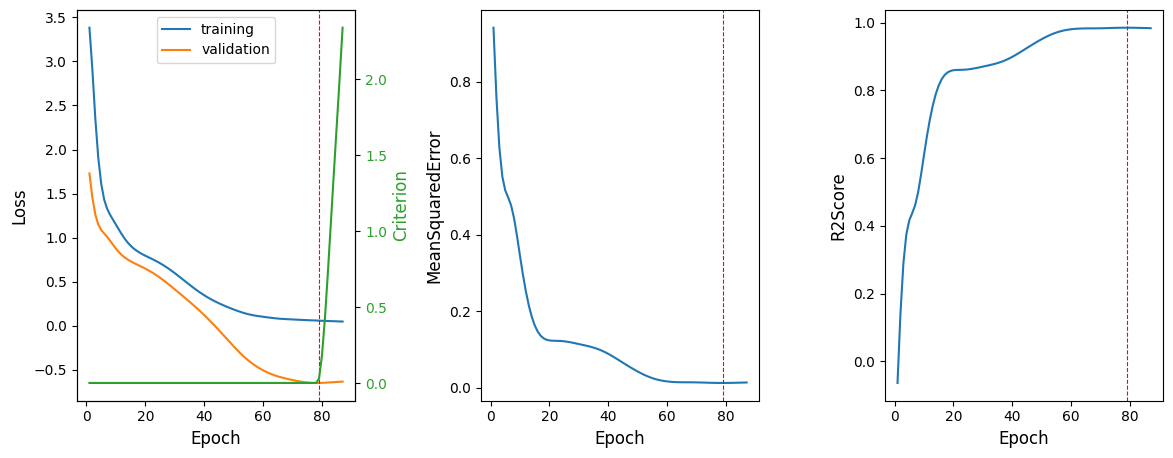

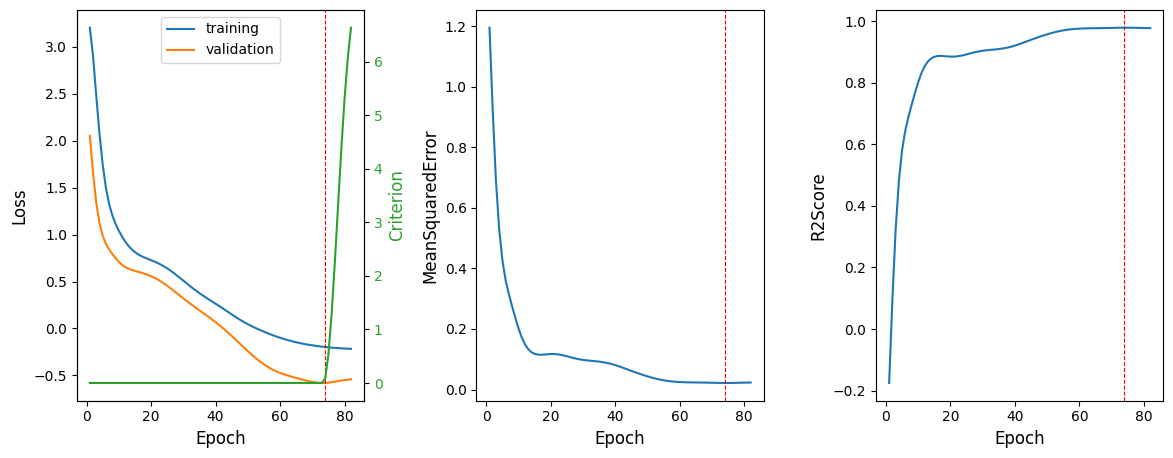

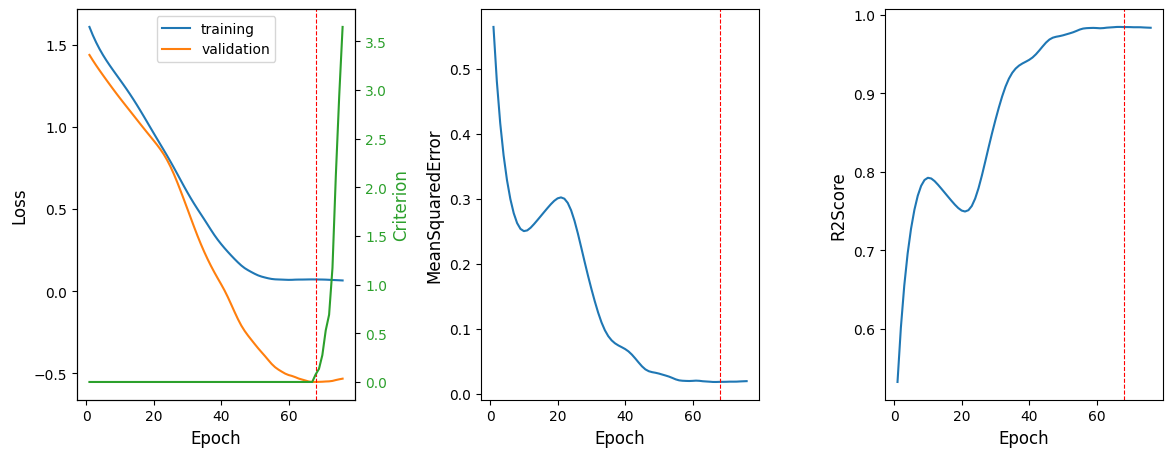

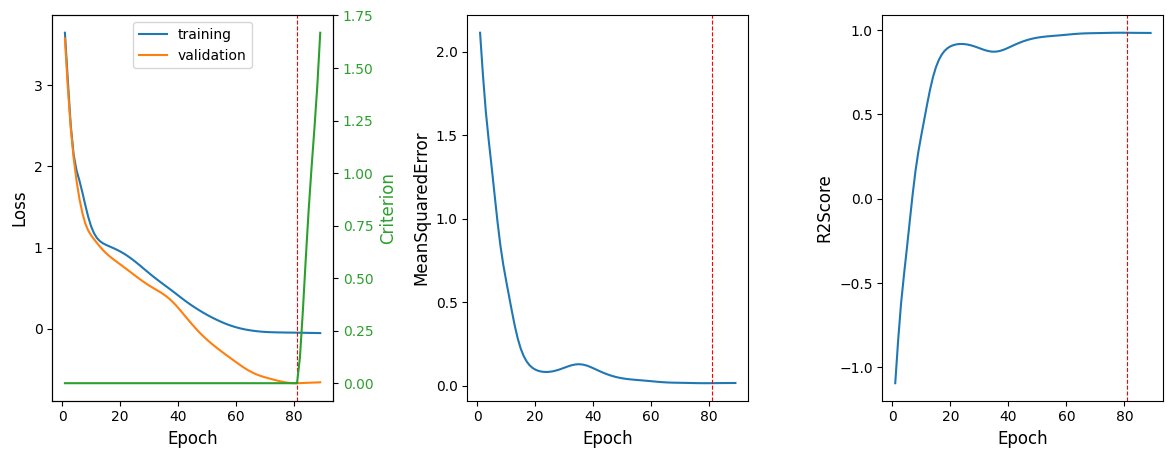

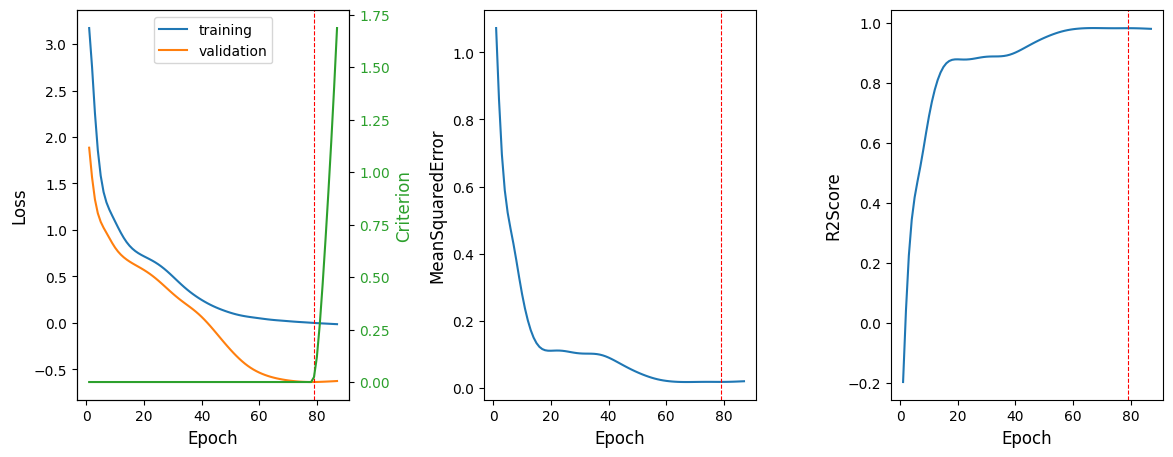

In [9]:
# check training stats at each split
for _, bts in best_train_stats_dct.items():
    bts.plot(with_early_stopping_criterion=True)

In [10]:
# best-split emulator (according to highest R2-score) is automatically available within kfcv instance
from GPErks.perks.inference import Inference

inference = Inference(kfcv.emulator)
inference.summary()

# check best-split emulator fitted hyperparameters
kfcv.emulator.hyperparameters()

# note the size differences between train and test sets here compared to original dataset train and val sets
kfcv.emulator.experiment.dataset.summary()

                   Score
MeanSquaredError  0.0003
R2Score           0.9827

Bias: -1.0505
Weights: tensor([-0.0702,  0.7047,  0.1861, -0.0989,  1.1047])
Outputscale: 0.4213
Lengthscales: tensor([2.0812, 0.8537, 3.2730, 3.2734, 0.1661])
Likelihood noise: 0.0184

CanopyReflectance dataset loaded.
Notes from the author:
"A reflectance model for the homogeneous plant canopy and its inversion (doi.org/10.1016/0034-4257(89)90015-1)"
Dataset properties:
-Input size: 5
-Input parameters: ['view_zenith', 'LAI', 'sl', 'lmbd_z', 'lambda']
-Output size: 1
-Output feature: ['Canopy_Reflectance']
-Sample size: 51
-Discrepancy: 0.0405
-Validation data available: No
-Testing data available: Yes (size = 13)
